In [3]:
import numpy as np
import random
import heapq
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, mutual_info_score
from skimage.metrics import structural_similarity as SSIM

In [4]:
image = np.load('images.npy')
labels = np.load('labels.npy')
num_bands = image.shape[-1] 
print(image.shape)

(1243, 684, 224)


In [3]:
first_image = image[0:128, 0:128, :]
nmi_matrix = np.zeros((num_bands, num_bands))
ssim_matrix = np.zeros((num_bands, num_bands))
dissimilarity_matrix = np.zeros((num_bands, num_bands))

In [4]:
def calculate_entropy(data):
    _, counts = np.unique(data, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities)) if len(probabilities) > 1 else 0
for i in range(num_bands):
    for j in range(i + 1, num_bands):
        band_i = first_image[:, :, i].flatten()
        band_j = first_image[:, :, j].flatten()
        if len(np.unique(band_i)) > 1 and len(np.unique(band_j)) > 1:
            mi = mutual_info_score(band_i, band_j)
            h_i, h_j = calculate_entropy(band_i), calculate_entropy(band_j)
            if h_i > 0 and h_j > 0:
                dissimilarity_matrix[i, j] = h_i + h_j - 2 * mi
                dissimilarity_matrix[j, i] = dissimilarity_matrix[i, j]
                nmi_matrix[i, j] = 2 * mi / (h_i + h_j)
                nmi_matrix[j, i] = nmi_matrix[i, j]
            
            ssim_value = SSIM(
                first_image[:, :, i], first_image[:, :, j],
                data_range=first_image[:, :, i].max() - first_image[:, :, i].min()
            )
            ssim_matrix[i, j] = ssim_value
            ssim_matrix[j, i] = ssim_value
hybrid_similarity_matrix = nmi_matrix + ssim_matrix
def rank_bands(sim_matrix, dis_matrix, num_bands_to_select=50):
    avg_similarity = np.nanmean(sim_matrix, axis=1)
    dissimilarity = np.nanmin(dis_matrix, axis=1)
    scores = avg_similarity * dissimilarity
    return np.argsort(scores)[::-1][:num_bands_to_select]  
num_bands_to_select = 100
sr_nmi_vi_ranked_bands = rank_bands(nmi_matrix, dissimilarity_matrix, num_bands_to_select)

print(f"Top {num_bands_to_select} SR-NMI-VI Ranked Bands: {sr_nmi_vi_ranked_bands}")


Top 100 SR-NMI-VI Ranked Bands: [223 222  81  80  79  78  77  76  75  74  73  72  71  70  69  68  67  66
  65  64  63  62  61  60  59  58  57  82  83  84  98 109 108 107 106 105
 104 103 102 101 100  99  97  85  96  95  94  93  92  91  90  89  88  87
  86  56  55  54  13  24  23  22  21  20  19  18  17  16  15  14  12  26
  11  10   9   8   7   6   5   4   3   2   1  25  27  53  41  52  51  50
  49  48  47  46  45  44  43  42  40  28]


In [5]:
import numpy as np
import random
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score

POP_SIZE = 50   
N_GEN = 50     
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.7
MIN_BANDS = 10  
MAX_BANDS = 20 
sr_nmi_vi_ranked_bands = sr_nmi_vi_ranked_bands.tolist() if isinstance(sr_nmi_vi_ranked_bands, np.ndarray) else sr_nmi_vi_ranked_bands
try:
    del creator.FitnessMax
    del creator.Individual
except AttributeError:
    pass

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize an individual with a random number of bands between MIN_BANDS and MAX_BANDS
def init_individual():
    num_selected_bands = random.randint(MIN_BANDS, MAX_BANDS)
    return creator.Individual(random.sample(sr_nmi_vi_ranked_bands, num_selected_bands))

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Mutation: Replace one band while maintaining the length constraint
def mutate_individual(individual):
    if random.random() < MUTATION_RATE:
        idx_to_replace = random.randint(0, len(individual) - 1)
        available_bands = list(set(sr_nmi_vi_ranked_bands) - set(individual))
        if available_bands:
            individual[idx_to_replace] = random.choice(available_bands)
    return (individual,)

# Crossover: Ensure the number of bands remains within constraints
def crossover(parent1, parent2):
    crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    
    child1_genes = list(set(parent1[:crossover_point] + parent2[crossover_point:]))
    child2_genes = list(set(parent2[:crossover_point] + parent1[crossover_point:]))

    # Ensure valid band count
    child1_genes = child1_genes[:MAX_BANDS] if len(child1_genes) > MAX_BANDS else child1_genes
    child2_genes = child2_genes[:MAX_BANDS] if len(child2_genes) > MAX_BANDS else child2_genes
    
    # Fill up to MIN_BANDS if needed
    while len(child1_genes) < MIN_BANDS:
        new_band = random.choice(sr_nmi_vi_ranked_bands)
        if new_band not in child1_genes:
            child1_genes.append(new_band)
    
    while len(child2_genes) < MIN_BANDS:
        new_band = random.choice(sr_nmi_vi_ranked_bands)
        if new_band not in child2_genes:
            child2_genes.append(new_band)

    return creator.Individual(child1_genes), creator.Individual(child2_genes)

# Fitness function using SVM classification
def evaluate(individual):
    selected_indices = list(individual)
    X = image.reshape(-1, num_bands)[:, selected_indices]
    y = labels.ravel()

    # Use a subset of the dataset
    X = X[102000:109000, :]
    y = y[102000:109000]

    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        return (0,)  

    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    if len(np.unique(y_train)) < 2:
        return (0,)
    
    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    return (acc + kappa + f1,)

toolbox.register("mate", crossover)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run Genetic Algorithm
def run_ga():
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)  
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE, 
                        ngen=N_GEN, stats=stats, halloffame=hof, verbose=True)

    return hof[0]  

best_individual = run_ga()
print(f"Optimized Bands (GA-Wrapped SR-NMI-VI): {best_individual}")


gen	nevals	max  
0  	50    	2.719
1  	40    	2.719
2  	39    	2.72017
3  	41    	2.72782
4  	45    	2.76063
5  	44    	2.74299
6  	38    	2.74796
7  	38    	2.76102
8  	39    	2.76102
9  	36    	2.75935
10 	39    	2.76192
11 	42    	2.76464
12 	38    	2.76464
13 	32    	2.76464
14 	45    	2.75196
15 	41    	2.75974
16 	34    	2.77768
17 	36    	2.7631 
18 	39    	2.76859
19 	44    	2.75738
20 	41    	2.76518
21 	43    	2.76872
22 	35    	2.76872
23 	41    	2.76872
24 	36    	2.76872
25 	38    	2.77594
26 	36    	2.77594
27 	35    	2.77594
28 	37    	2.77594
29 	31    	2.77594
30 	40    	2.77594
31 	33    	2.77594
32 	44    	2.77594
33 	42    	2.78505
34 	40    	2.76822
35 	40    	2.76257
36 	38    	2.76464
37 	33    	2.76464
38 	40    	2.76464
39 	38    	2.76464
40 	45    	2.7784 
41 	42    	2.76993
42 	38    	2.75777
43 	43    	2.77834
44 	32    	2.75857
45 	45    	2.76933
46 	37    	2.75998
47 	35    	2.76747
48 	33    	2.76747
49 	39    	2.76747
50 	38    	2.76747
Optimized Bands (G

In [6]:

X = image.reshape(-1, num_bands)[:, best_individual]
y = labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"{name} - Accuracy: {acc:.4f}, Kappa: {kappa:.4f}, F1-score: {f1:.4f}")


Decision Tree - Accuracy: 0.9815, Kappa: 0.7233, F1-score: 0.9815
Naïve Bayes - Accuracy: 0.9671, Kappa: 0.6064, F1-score: 0.9704
SVM - Accuracy: 0.9846, Kappa: 0.7482, F1-score: 0.9839
Random Forest - Accuracy: 0.9865, Kappa: 0.7899, F1-score: 0.9862


In [ ]:
Decision Tree - Accuracy: 0.9815, Kappa: 0.7229, F1-score: 0.9815
Naïve Bayes - Accuracy: 0.9734, Kappa: 0.6258, F1-score: 0.9743
SVM - Accuracy: 0.9851, Kappa: 0.7566, F1-score: 0.9844
Random Forest - Accuracy: 0.9872, Kappa: 0.8001, F1-score: 0.9869

In [5]:
selected_sr_nmi_vi= [
    223, 222, 81, 80, 79, 78, 77, 76, 75, 74, 
    73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 
    63, 62, 61, 60, 59, 58, 57, 82, 83, 84, 
    98, 109, 108, 107, 106, 105, 104, 103, 102, 101, 
    100, 99, 97, 85, 96, 95, 94, 93, 92, 91
]

num_bands = image.shape[-1]
y = labels.ravel()
accuracies = []

for num_selected in range(1, len(selected_sr_nmi_vi) + 1):
    X = image.reshape(-1, num_bands)[:, selected_sr_nmi_vi[:num_selected]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    print(f"Bands: {num_selected}, Decision Tree - Accuracy: {acc:.4f}")

print("Final Accuracies:", accuracies)


Bands: 1, Decision Tree - Accuracy: 0.9655
Bands: 2, Decision Tree - Accuracy: 0.9655
Bands: 3, Decision Tree - Accuracy: 0.9687
Bands: 4, Decision Tree - Accuracy: 0.9702
Bands: 5, Decision Tree - Accuracy: 0.9744
Bands: 6, Decision Tree - Accuracy: 0.9724
Bands: 7, Decision Tree - Accuracy: 0.9715
Bands: 8, Decision Tree - Accuracy: 0.9721
Bands: 9, Decision Tree - Accuracy: 0.9721
Bands: 10, Decision Tree - Accuracy: 0.9715
Bands: 11, Decision Tree - Accuracy: 0.9723
Bands: 12, Decision Tree - Accuracy: 0.9741
Bands: 13, Decision Tree - Accuracy: 0.9740
Bands: 14, Decision Tree - Accuracy: 0.9758
Bands: 15, Decision Tree - Accuracy: 0.9762
Bands: 16, Decision Tree - Accuracy: 0.9762
Bands: 17, Decision Tree - Accuracy: 0.9757
Bands: 18, Decision Tree - Accuracy: 0.9770
Bands: 19, Decision Tree - Accuracy: 0.9766
Bands: 20, Decision Tree - Accuracy: 0.9766
Bands: 21, Decision Tree - Accuracy: 0.9764
Bands: 22, Decision Tree - Accuracy: 0.9766
Bands: 23, Decision Tree - Accuracy: 0.97

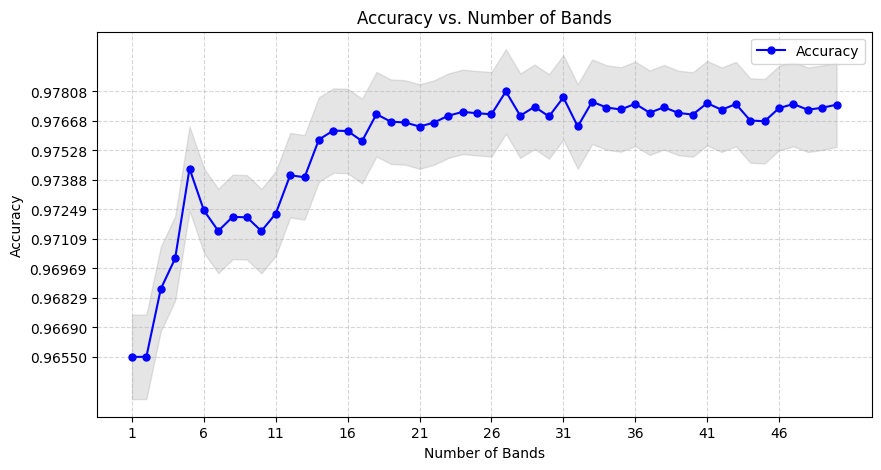

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data
bands = np.arange(1, 51)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(bands, accuracies, marker='o', linestyle='-', color='b', markersize=5, label='Accuracy')

# Highlight minor variations
plt.fill_between(bands, np.array(accuracies) - 0.002, np.array(accuracies) + 0.002, color='gray', alpha=0.2)

# Labels and Title
plt.xlabel("Number of Bands")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Bands")
plt.xticks(np.arange(1, 51, 5))
plt.yticks(np.linspace(min(accuracies), max(accuracies), 10))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Show plot
plt.show()


In [7]:
import numpy as np
import random
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, mutual_info_score
from sklearn.tree import DecisionTreeClassifier
image = np.load('images.npy')
labels = np.load('labels.npy')
num_bands = image.shape[-1]  
print(image.shape)
print(labels.shape)

(1243, 684, 224)
(1243, 684)


In [8]:
sr_nmi_vi_ranked_bands=[223 ,222,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,  67,  66,
  65,  64,  63,  62,  61,  60,  59,  58,  57,  82,  83,  84,  98, 109, 108, 107, 106, 105,
 104, 103, 102, 101, 100,  99,  97,  85,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,
  86,  56,  55,  54,  13,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  12,  26,
  11, 10,   9,   8,   7,   6,   5,   4 ,  3 ,  2 ,  1 , 25 , 27 , 53 , 41 , 52 , 51 , 50,
  49 , 48 , 47 , 46 , 45 , 44 , 43 , 42 , 40 , 28]

In [9]:
POP_SIZE = 10   
N_GEN = 30     
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.7

# Initialize DEAP
try:
    del creator.FitnessMax
    del creator.Individual
except AttributeError:
    pass

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


2
gen	nevals	max    
0  	10    	2.72362
1  	8     	2.84549
2  	9     	2.78477
3  	8     	2.85344
4  	6     	2.7934 
5  	5     	2.7934 
6  	9     	2.8326 
7  	8     	2.78341
8  	6     	2.8126 
9  	8     	2.77535
10 	8     	2.84549
11 	6     	2.84549
12 	6     	2.84549
13 	10    	2.80134
14 	10    	2.84549
15 	10    	2.88522
16 	9     	2.88522
17 	6     	2.88522
18 	7     	2.88522
19 	8     	2.87474
20 	8     	2.87474
21 	8     	2.81996
22 	9     	2.8126 
23 	9     	2.82527
24 	9     	2.8326 
25 	8     	2.86497
26 	8     	2.83931
27 	6     	2.83931
28 	8     	2.88522
29 	4     	2.88522
30 	6     	2.88522
Optimized Bands (GA-Wrapped SR-NMI-VI): [58, 23]
Bands: 2, Accuracy: 0.9768
3
gen	nevals	max    
0  	10    	2.80134
1  	8     	2.76575
2  	10    	2.76575
3  	5     	2.76575
4  	5     	2.80134
5  	10    	2.83931
6  	4     	2.8326 
7  	10    	2.83879
8  	8     	2.83879
9  	10    	2.8326 
10 	7     	2.84549
11 	7     	2.84549
12 	7     	2.84549
13 	9     	2.84549
14 	8     	2.84549
15 	6   

22 	7     	2.90998
23 	4     	2.90998
24 	6     	2.90998
25 	7     	2.90998
26 	4     	2.90998
27 	9     	2.90998
28 	9     	2.90998
29 	9     	2.88043
30 	8     	2.85945
Optimized Bands (GA-Wrapped SR-NMI-VI): [6, 71, 43, 108, 12, 16, 17, 19, 83, 20, 57, 28, 95]
Bands: 13, Accuracy: 0.9815
14
gen	nevals	max    
0  	10    	2.88522
1  	8     	2.88522
2  	9     	2.88963
3  	7     	2.88963
4  	9     	2.87474
5  	7     	2.85118
6  	6     	2.9023 
7  	5     	2.9023 
8  	6     	2.90998
9  	8     	2.90998
10 	8     	2.90998
11 	5     	2.90998
12 	10    	2.81996
13 	10    	2.9023 
14 	7     	2.93378
15 	6     	2.93378
16 	8     	2.90998
17 	9     	2.88963
18 	8     	2.8791 
19 	10    	2.93113
20 	6     	2.93113
21 	10    	2.84549
22 	8     	2.88043
23 	8     	2.88963
24 	10    	2.93113
25 	8     	2.88522
26 	9     	2.93113
27 	7     	2.90998
28 	5     	2.9063 
29 	9     	2.90998
30 	6     	2.93378
Optimized Bands (GA-Wrapped SR-NMI-VI): [4, 103, 104, 106, 11, 14, 47, 82, 52, 24, 26, 60, 62, 42

18 	10    	2.88522
19 	6     	2.86497
20 	9     	2.90998
21 	9     	2.85118
22 	3     	2.82673
23 	6     	2.88043
24 	7     	2.88043
25 	10    	2.85945
26 	8     	2.85945
27 	9     	2.85945
28 	6     	2.85945
29 	8     	2.85945
30 	7     	2.88522
Optimized Bands (GA-Wrapped SR-NMI-VI): [3, 75, 7, 12, 19, 21, 40, 43, 47, 48, 50, 53, 61, 63, 65, 74, 82, 87, 90, 93, 223, 99, 105, 106]
Bands: 24, Accuracy: 0.9815
25
gen	nevals	max    
0  	10    	2.85945
1  	7     	2.85945
2  	5     	2.85344
3  	9     	2.85645
4  	4     	2.8937 
5  	7     	2.8937 
6  	8     	2.8937 
7  	8     	2.8937 
8  	10    	2.8126 
9  	7     	2.84549
10 	4     	2.9023 
11 	8     	2.9023 
12 	8     	2.87005
13 	8     	2.86497
14 	6     	2.88043
15 	10    	2.85118
16 	7     	2.88043
17 	8     	2.86497
18 	6     	2.86497
19 	6     	2.88522
20 	6     	2.9063 
21 	6     	2.9063 
22 	6     	2.88963
23 	7     	2.88963
24 	8     	2.90998
25 	8     	2.88963
26 	10    	2.95668
27 	6     	2.88522
28 	10    	2.88522
29 	8     	2.8

Bands: 34, Accuracy: 0.9819
35
gen	nevals	max    
0  	10    	2.87005
1  	7     	2.83299
2  	10    	2.85344
3  	6     	2.85344
4  	8     	2.84549
5  	8     	2.86497
6  	9     	2.8126 
7  	9     	2.85945
8  	9     	2.83931
9  	9     	2.86497
10 	9     	2.86497
11 	8     	2.82673
12 	9     	2.85945
13 	6     	2.8326 
14 	4     	2.8326 
15 	4     	2.8752 
16 	5     	2.8752 
17 	6     	2.85945
18 	10    	2.8326 
19 	6     	2.87005
20 	5     	2.91337
21 	7     	2.91337
22 	9     	2.8326 
23 	9     	2.88963
24 	8     	2.8326 
25 	2     	2.8326 
26 	4     	2.8326 
27 	4     	2.8326 
28 	6     	2.83931
29 	5     	2.83931
30 	6     	2.88043
Optimized Bands (GA-Wrapped SR-NMI-VI): [5, 7, 8, 11, 12, 15, 16, 17, 19, 40, 43, 44, 46, 48, 53, 56, 57, 58, 67, 70, 71, 76, 83, 85, 86, 87, 89, 94, 222, 97, 98, 101, 103, 104, 106]
Bands: 35, Accuracy: 0.9815
36
gen	nevals	max    
0  	10    	2.87005
1  	7     	2.87005
2  	7     	2.87005
3  	7     	2.88522
4  	9     	2.82673
5  	8     	2.84549
6  	10    	2.8

Bands: 44, Accuracy: 0.9813
45
gen	nevals	max    
0  	10    	2.85344
1  	8     	2.84549
2  	8     	2.88043
3  	8     	2.92826
4  	7     	2.92826
5  	10    	2.88522
6  	8     	2.88522
7  	8     	2.86497
8  	5     	2.86497
9  	7     	2.86497
10 	8     	2.85645
11 	10    	2.86497
12 	8     	2.85344
13 	9     	2.86497
14 	7     	2.87005
15 	8     	2.8126 
16 	5     	2.82673
17 	6     	2.88963
18 	10    	2.87005
19 	10    	2.85344
20 	10    	2.84549
21 	8     	2.88043
22 	3     	2.88043
23 	6     	2.88043
24 	8     	2.88043
25 	6     	2.88043
26 	8     	2.88043
27 	8     	2.9023 
28 	8     	2.87474
29 	10    	2.87005
30 	5     	2.88522
Optimized Bands (GA-Wrapped SR-NMI-VI): [1, 2, 6, 8, 9, 10, 12, 13, 16, 18, 20, 22, 23, 26, 41, 42, 44, 45, 46, 50, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 66, 68, 70, 74, 75, 82, 83, 87, 90, 93, 223, 99, 105, 107, 108]
Bands: 45, Accuracy: 0.9814
46
gen	nevals	max    
0  	10    	2.88043
1  	5     	2.88043
2  	6     	2.88043
3  	8     	2.88043
4  	8     	2.88

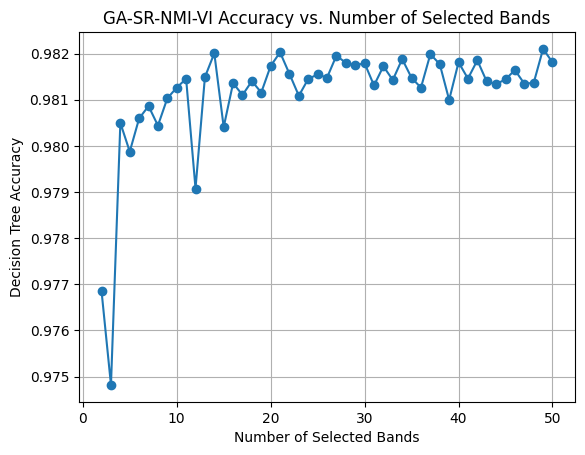

In [10]:
sr_nmi_vi_ranked_bands = sr_nmi_vi_ranked_bands.tolist() if isinstance(sr_nmi_vi_ranked_bands, np.ndarray) else sr_nmi_vi_ranked_bands

def init_individual():
    return creator.Individual(random.sample(sr_nmi_vi_ranked_bands, N_BANDS))

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def mutate_individual(individual):
    if random.random() < MUTATION_RATE:
        idx_to_replace = random.randint(0, len(individual) - 1)
        available_bands = list(set(sr_nmi_vi_ranked_bands) - set(individual))
        if available_bands:
            individual[idx_to_replace] = random.choice(available_bands)
    return (individual,)
def crossover(parent1, parent2):
    crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child1_genes = list(set(parent1[:crossover_point] + parent2[crossover_point:]))[:N_BANDS]
    child2_genes = list(set(parent2[:crossover_point] + parent1[crossover_point:]))[:N_BANDS]
    while len(child1_genes) < N_BANDS:
        new_band = random.choice(sr_nmi_vi_ranked_bands)
        if new_band not in child1_genes:
            child1_genes.append(new_band)
    while len(child2_genes) < N_BANDS:
        new_band = random.choice(sr_nmi_vi_ranked_bands)
        if new_band not in child2_genes:
            child2_genes.append(new_band)
    return creator.Individual(child1_genes), creator.Individual(child2_genes)
def evaluate(individual):
    selected_indices = list(individual)
    X = image.reshape(-1, num_bands)[:, selected_indices]
    y = labels.ravel()
    X = X[0:5000, :]
    y = y[0:5000]
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        return (0,)  
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    if len(np.unique(y_train)) < 2:
        return (0,)
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    return (acc + kappa + f1,)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)
def run_ga():
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)  
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE, 
                        ngen=N_GEN, stats=stats, halloffame=hof, verbose=True)

    return hof[0]  

accuracies = []
num_band_range = np.arange(2, 51)
for N_BANDS in num_band_range:
    print(N_BANDS)
    best_individual = run_ga()
    print(f"Optimized Bands (GA-Wrapped SR-NMI-VI): {best_individual}")
    selected_bands = list(best_individual)
    X = image.reshape(-1, num_bands)[:, selected_bands]
    y = labels.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Bands: {N_BANDS}, Accuracy: {acc:.4f}")

plt.plot(num_band_range, accuracies, marker='o')
plt.xlabel("Number of Selected Bands")
plt.ylabel("Decision Tree Accuracy")
plt.title("GA-SR-NMI-VI Accuracy vs. Number of Selected Bands")
plt.grid(True)
plt.show()

In [11]:
print (accuracies)

[0.9768450271304457, 0.9748180848728162, 0.9804990120126713, 0.979875639055296, 0.9805970266286108, 0.9808636263839664, 0.9804402032431077, 0.9810322115233824, 0.9812635260169996, 0.9814556346642411, 0.9790758397892294, 0.9814909199259794, 0.9820084370981401, 0.9804088385660069, 0.9813615406329392, 0.9811027820468589, 0.9814046670639526, 0.981157670231785, 0.9817339961735094, 0.9820280400213279, 0.9815614904494558, 0.9810870997083085, 0.9814517140796035, 0.9815497286955431, 0.9814791581720667, 0.9819574694978516, 0.9818006461123483, 0.9817457579274221, 0.9817928049430731, 0.9813105730326507, 0.9817261550042342, 0.9814281905717781, 0.9818829783897375, 0.981475237587429, 0.9812635260169996, 0.9819888341749522, 0.9817732020198852, 0.9809969262616441, 0.981812407866261, 0.9814595552488787, 0.9818555342972745, 0.9813968258946774, 0.9813380171251137, 0.9814438729103284, 0.981643822726845, 0.9813497788790264, 0.9813654612175767, 0.982102531129442, 0.981812407866261]


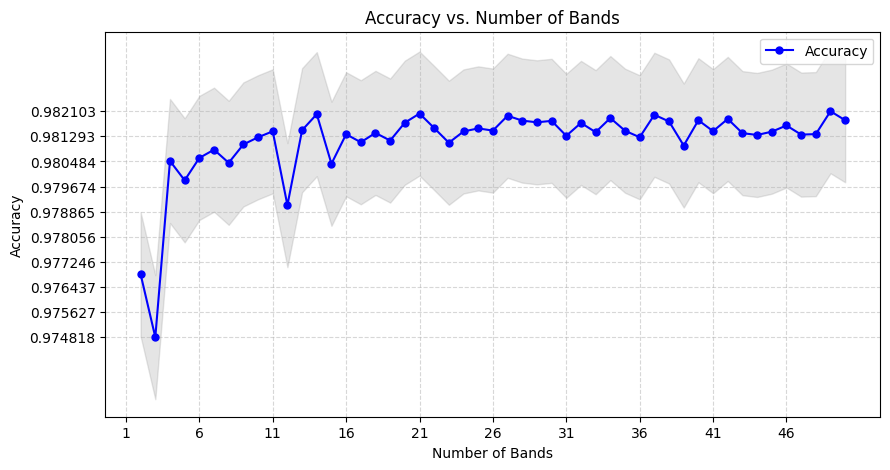

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data
bands = np.arange(2, 51)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(bands, accuracies, marker='o', linestyle='-', color='b', markersize=5, label='Accuracy')

# Highlight minor variations
plt.fill_between(bands, np.array(accuracies) - 0.002, np.array(accuracies) + 0.002, color='gray', alpha=0.2)

# Labels and Title
plt.xlabel("Number of Bands")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Bands")
plt.xticks(np.arange(1, 51, 5))
plt.yticks(np.linspace(min(accuracies), max(accuracies), 10))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Show plot
plt.show()


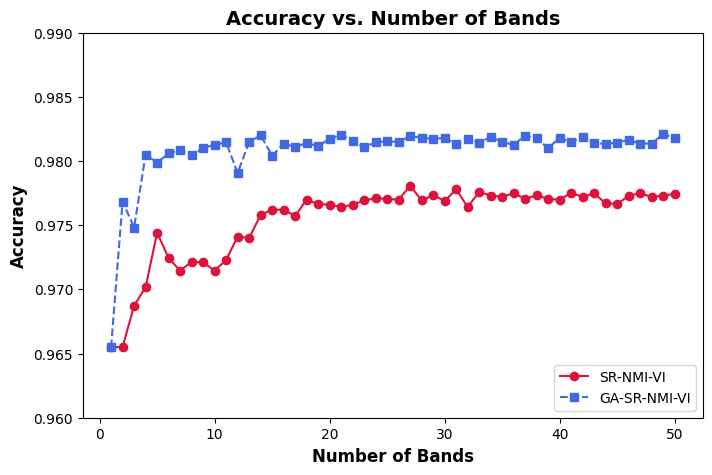

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (Replace these with your actual accuracy values)
num_bands = np.arange(1, 51)
accuracy1 = [0.9654988551892858, 0.9655106169431986, 0.9687176551767399, 0.970168271492645, 0.9744221058244206, 0.9724422105824421, 0.9714699055923219, 0.9721364049807107, 0.9721128814728852, 0.9714620644230467, 0.972293228366214, 0.974108459053414, 0.9740104444374745, 0.9757982310322115, 0.9762216541730703, 0.9762020512498824, 0.9757237399240974, 0.9769979299313114, 0.976645077313929, 0.9766058714675533, 0.9764137628203118, 0.9766019508829157, 0.9769273594078349, 0.9771077063011636, 0.9770449769469624, 0.9769940093466738, 0.9780760907066461, 0.9769273594078349, 0.9773507825486937, 0.9768920741460967, 0.9777938086127403, 0.9764176834049494, 0.9775899382115861, 0.9773154972869554, 0.9772214032556534, 0.9774919235956466, 0.9770685004547878, 0.9773272590408681, 0.9770567387008751, 0.976982247592761, 0.9775232882727473, 0.9772096415017407, 0.9774762412570963, 0.9766999654988552, 0.9766646802371169, 0.9772880531944924, 0.9774801618417338, 0.9772096415017407, 0.9773037355330427, 0.9774487971646332]
accuracy2 = [0.9654988551892858,0.9768450271304457, 0.9748180848728162, 0.9804990120126713, 0.979875639055296, 0.9805970266286108, 0.9808636263839664, 0.9804402032431077, 0.9810322115233824, 0.9812635260169996, 0.9814556346642411, 0.9790758397892294, 0.9814909199259794, 0.9820084370981401, 0.9804088385660069, 0.9813615406329392, 0.9811027820468589, 0.9814046670639526, 0.981157670231785, 0.9817339961735094, 0.9820280400213279, 0.9815614904494558, 0.9810870997083085, 0.9814517140796035, 0.9815497286955431, 0.9814791581720667, 0.9819574694978516, 0.9818006461123483, 0.9817457579274221, 0.9817928049430731, 0.9813105730326507, 0.9817261550042342, 0.9814281905717781, 0.9818829783897375, 0.981475237587429, 0.9812635260169996, 0.9819888341749522, 0.9817732020198852, 0.9809969262616441, 0.981812407866261, 0.9814595552488787, 0.9818555342972745, 0.9813968258946774, 0.9813380171251137, 0.9814438729103284, 0.981643822726845, 0.9813497788790264, 0.9813654612175767, 0.982102531129442, 0.981812407866261]
# Plot
plt.figure(figsize=(8, 5))
plt.plot(num_bands, accuracy1, marker='o', linestyle='-', color='crimson', label='SR-NMI-VI')
plt.plot(num_bands, accuracy2, marker='s', linestyle='--', color='royalblue', label='GA-SR-NMI-VI')

# Labels and title
plt.xlabel("Number of Bands", fontsize=12, fontweight='bold', color='black')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold', color='black')
plt.title("Accuracy vs. Number of Bands", fontsize=14, fontweight='bold', color='black')

# Set y-axis limits based on accuracy range
plt.ylim(0.96, 0.99)  # Adjusted to focus on your accuracy range

# Legend
plt.legend(loc='lower right', fontsize=10)

plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Show plot
plt.show()
